# 10 Fold Cross-Validation across all models
Below is the code used to conduct our 10-fold cross validations. The results shown here are those that are published in our work. Note that this code is extremely computationally expensive, and that it may take 24+ hours to conduct each CV. 

In [1]:
import pickle
import multiprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from datetime import date
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Flatten, Input, Activation, PReLU
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model
from IPython.display import display
from IPython.display import Image 
from statistics import mean 

from sklearn.model_selection import KFold, TimeSeriesSplit
from collections import defaultdict

In [2]:
# Set Styling
from simple_colors import *
sns.set_style('dark')
sns.set_palette('RdBu')

## Load Data

In [3]:
# Google Trends Data
individual_search_term_frequencies = pd.read_pickle('./pickles/individual_search_term_frequencies.pkl')

# Spotify data
top_200_weighted_avg = pd.read_pickle('./pickles/top_200_weighted_avg.pkl')

# News vectors
news_vectors = pd.read_pickle('./pickles/news_vectors.pkl')

In [4]:
# Convert to float32 to decrease training time (single precision training is faster)
dates = pd.DataFrame(individual_search_term_frequencies['date'])
individual_search_term_frequencies = individual_search_term_frequencies.drop(columns='date').astype('float32')
top_200_weighted_avg = top_200_weighted_avg.drop(columns='date').astype('float32')
news_vectors = news_vectors.drop(columns='date').astype('float32')

In [5]:
individual_search_term_frequencies = dates.join(individual_search_term_frequencies)
top_200_weighted_avg = dates.join(top_200_weighted_avg)
news_vectors = dates.join(news_vectors)

In [6]:
individual_search_term_frequencies.tail()

,date,anxiety,depression,OCD,hopeless,angry,afraid,apathy,worthless,worried,restless,irritable,tense,scattered,tired,avoiding,procrastinate,insomnia,suicidal,suicide
1359,2020-09-25,116.071365,75.903046,72.121307,206.203384,52.829632,42.324825,49.008110,76.131248,123.624023,44.724663,75.738869,115.184357,99.817886,74.476944,29.878313,47.112103,72.179741,127.555321,40.619518
1360,2020-09-26,106.732292,69.652206,74.968201,168.937714,56.201733,38.711731,53.675552,84.040993,84.991516,37.088745,75.738869,83.265800,84.461288,71.937950,32.679405,42.332611,75.511116,137.243073,40.022175
1361,2020-09-27,109.400597,74.117088,79.713020,166.453323,52.829632,39.227886,44.340672,98.871758,88.082115,38.725014,73.821426,80.490273,81.901855,73.630608,31.278858,47.112103,74.400658,138.857697,45.398285
1362,2020-09-28,122.742134,79.474953,81.610947,193.781494,51.705597,41.808666,58.342991,91.950729,135.986420,43.088394,72.862709,124.898705,101.097603,77.015930,35.480495,66.230057,72.179741,138.857697,41.216866
1363,2020-09-29,122.742134,79.474953,79.713020,193.781494,49.457527,41.292511,60.676708,68.221512,123.624023,45.270088,72.862709,127.674232,104.936752,73.630608,42.016376,52.574375,69.958824,156.618561,39.424828


## Define Training Process for LSTM Model

In [17]:
def plot_loss(history, title, label_name, save=False, fname=None):
    """
    Show the model's loss on training and validation data for each training epoch in the training trial
    """
    plt.title(title)
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylim([min(history.history['val_loss']), max(history.history['loss'])])
    plt.xlabel('Epoch')
    plt.ylabel('Error -' + label_name)
    plt.legend()
    plt.grid(True)
    
    # Display the figure
    figure = plt.gcf()
    display(figure)
    plt.close()

    
    if save:
        if fname is None:
            fname = './figures/history.png'
        
        plt.savefig(fname)

In [18]:
def plot_predictions(test_predictions, test_labels, model_name, label_name):
    
    r2 = round(r2_score(y_true=test_labels, y_pred=test_predictions), 3)
    plt.title(model_name + ' - R²=' + str(r2))
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [' + label_name + ']')
    plt.ylabel('Predictions [' + label_name + ']')
    lims = [min(test_labels), max(test_labels)]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

In [19]:
def get_rnn_forecasting_data_monthly_predictions(data, labels, step, normalize=True):
    
    if normalize:
        normalized_data = (data - data.mean()) / data.std()
        samples_list = normalized_data.values.tolist()
    else:
        samples_list = data.values.tolist() 
        
    rnn_samples = []
    # Collect 30 days of data, including all data points in the set [i - 30, i)
    # For each data point in the dataset.
    for i in range(step, len(samples_list) - 30): # starts at day 30
        sample_set = np.array(samples_list[i - step: i])
        
        # Expand shape if neccessary
        if len(sample_set.shape) < 2:
            sample_set = np.expand_dims(sample_set, axis=1)
            
        rnn_samples.append(sample_set)

    lstm_data = np.array(rnn_samples)
    
    # Use the above sets of 30 days to predict the average Google Trends scores
    # in the SUBSEQUENT 30 days
    label_list = labels.to_list()
    
    month_scores = []
    for i in range(2 * step, len(label_list)): # Starts at day 60
        month_score = mean(label_list[i - step: i]) # get the mean score for the previous 30 days
        month_scores.append(month_score)
        
    labels = pd.Series(np.array(month_scores))
    
    return lstm_data, labels

In [20]:
def build_lstm(features, model_name):
    
    input_layer_name = model_name + '_' + str(step) + '_Days'

    # Build and compile the model
    rnn_model = tf.keras.Sequential([
        layers.Input(shape=features[0].shape, name=input_layer_name),
        layers.LSTM(256, return_sequences=True),
        layers.LSTM(128),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1) # regression output
    ])
    
    rnn_model.compile(loss="mean_absolute_error", 
                      optimizer=tf.keras.optimizers.Nadam(0.001))
    
    return rnn_model

In [21]:
def train_lstm(model, train_features, train_labels, epochs):

    # Use multiple CPU cores if available
    workers = multiprocessing.cpu_count()
    use_multiprocessing = workers > 1

    # LSTMs tend to be more sporadic in terms of validation accuracy, so we will 
    # increase the patience to 100 for this model
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               restore_best_weights=True, patience=200)
    
    # Train the model
    history = model.fit(
        train_features, train_labels,
        batch_size=128, # batch size shoud be a power of 2
        validation_split=0.1, # 20% of data saved for validation
        callbacks=[early_stop], # stop when model begins overfitting
        verbose=0, # set to 1 to see validation accuracy at end of each training step
        epochs=epochs, # maximum training epochs (if model does not stop early)
        workers=workers, 
        use_multiprocessing=use_multiprocessing
    )

## Get Datasets for each model

In [22]:
# 30-day forecasting:
step = 30

In [23]:
def data_labels_and_models(trend_to_predict: str):

    # Trends Only - 19 * 30
    trends_lstm_data, labels = get_rnn_forecasting_data_monthly_predictions(
        data=individual_search_term_frequencies[trend_to_predict],
        labels=individual_search_term_frequencies[trend_to_predict],
        step=step
    )

    # Spotify Only - 13 * 30
    spotify_lstm_data, _ = get_rnn_forecasting_data_monthly_predictions(
        data=top_200_weighted_avg.drop(columns=['date']),
        labels=individual_search_term_frequencies[trend_to_predict],
        step=step
    )

    # NYT Only - 512 * 30
    nyt_lstm_data, _ = get_rnn_forecasting_data_monthly_predictions(
        data=news_vectors.drop(columns=['date']),
        labels=individual_search_term_frequencies[trend_to_predict],
        step=step
    )

    # Spotify + Trends - 32 * 30
    spotify_plus_trends = top_200_weighted_avg.drop(columns=['date']).join(
        individual_search_term_frequencies[trend_to_predict])

    spotify_trends_lstm_data, _ = get_rnn_forecasting_data_monthly_predictions(
        data=spotify_plus_trends,
        labels=individual_search_term_frequencies[trend_to_predict],
        step=step
    )

    # Spotify + NYT - 525 * 30
    spotify_plus_nyt = top_200_weighted_avg.drop(columns=['date']).join(
        news_vectors.drop(columns=['date']))

    spotify_nyt_lstm_data, _ = get_rnn_forecasting_data_monthly_predictions(
        data=spotify_plus_nyt,
        labels=individual_search_term_frequencies[trend_to_predict],
        step=step
    )

    # NYT + Trends - 531 * 30
    nyt_plus_trends = news_vectors.drop(columns=['date']).join(
        individual_search_term_frequencies[trend_to_predict])

    nyt_trends_lstm_data, _ = get_rnn_forecasting_data_monthly_predictions(
        data=nyt_plus_trends,
        labels=individual_search_term_frequencies[trend_to_predict],
        step=step
    )

    # Spotify + NYT + Trends - 544 * 30
    spotify_plus_nyt_plus_trends = spotify_plus_nyt.join(
        individual_search_term_frequencies[trend_to_predict])

    spotify_nyt_trends_lstm_data, _ = get_rnn_forecasting_data_monthly_predictions(
        data=spotify_plus_nyt_plus_trends,
        labels=individual_search_term_frequencies[trend_to_predict],
        step=step
    )
    
    model_names = ['trends_only', 'spotify_only', 'nyt_only', 'spotify_trends', 
                   'spotify_nyt', 'nyt_trends', 'spotify_nyt_trends']

    feature_sets = [trends_lstm_data, spotify_lstm_data, nyt_lstm_data, spotify_trends_lstm_data, 
                    spotify_nyt_lstm_data, nyt_trends_lstm_data, spotify_nyt_trends_lstm_data]    
    
    return feature_sets, labels, model_names

## Train Each Model using a 10-Fold Cross Validation

### Perform 10-Fold Cross Validation

In [14]:
# Generate Random Splits
from random import randint
random_seeds = []
folds = 10

for i in range(folds):
    random_seeds.append(randint(0,1000))

In [15]:
random_seeds

[658, 410, 216, 595, 484, 309, 138, 484, 544, 997]

In [24]:
def cross_validate(feature_sets, labels, model_names):

    # Test each of the 7 models
    for model_name, feature_set in zip(model_names, feature_sets):

        model_to_performances[model_name] = []
        model_to_predictions[model_name] = []

        # Perform a K-Fold split for each model to be tested.
        for i, seed in enumerate(random_seeds):

            # Peform Split
            train_features, test_features, train_labels, test_labels = train_test_split(
                feature_set, labels, test_size=0.1, random_state=seed)

            # Train Model
            model = build_lstm(train_features, model_name) # Compile / Reset Model
            train_lstm(model, train_features, train_labels, epochs=1000)

            # Evaluate Model Performance
            mae = model.evaluate(test_features, test_labels, verbose=0)
            model_to_performances[model_name].append(mae)

            # Get Predictions
            test_predictions = model.predict(test_features).flatten()
            model_to_predictions[model_name].append(test_predictions)

            # Output
            print('Fold', i, '- MAE of model', model_name, 'on Test Set:', mae)

        print()

        # Convert predictions across all folds to a single np array
        model_to_predictions[model_name] = np.concatenate(model_to_predictions[model_name])


### Generate error metrics and predictions for our baseline models

In [25]:
def zero_rule_performance(labels):
    
    # Zero Rule algorithm
    model_name = 'zero_rule'
    model_to_predictions[model_name] = []
    model_to_performances[model_name] = []
    for i, seed in enumerate(random_seeds):

        # Peform Split
        train_labels, test_labels = train_test_split(labels, test_size=0.2, random_state=seed)

        # Guess the mean of the training set each time:
        test_predictions = np.full(shape=test_labels.shape, fill_value=train_labels.mean())

        # Get the MAE on this split
        diff = test_predictions - test_labels
        mae = np.mean(abs(diff))
        model_to_performances[model_name].append(mae)

        # Get the predictions for this split
        model_to_predictions[model_name].append(test_predictions)


    # Save aggregates
    model_to_predictions[model_name] = np.concatenate(model_to_predictions[model_name])

In [26]:
def one_month_trailing_avg_performance(trend_to_predict):
    
    # One Month Training Average Model
    model_name = 'one_month_trailing_average'
    model_to_predictions[model_name] = []
    model_to_performances[model_name] = []

    # Get non-normalized trends data:
    non_normal_trends_lstm_data, labels = get_rnn_forecasting_data_monthly_predictions(
        data=individual_search_term_frequencies[trend_to_predict].astype('float32'),
        labels=individual_search_term_frequencies[trend_to_predict].astype('float32'),
        step=step,
        normalize=False
    )

    for i, seed in enumerate(random_seeds):

        # Perform split
        train_features, test_features, train_labels, test_labels = train_test_split(
            non_normal_trends_lstm_data, labels, test_size=0.2, random_state=seed)

        # Always guess the next month will have the same score as the current month
        test_predictions = np.squeeze(test_features.mean(axis=1)) # squeeze simply removes unneeded dimensions
        diff = test_predictions - test_labels
        mae = np.mean(abs(diff))
        model_to_performances[model_name].append(mae)

        # Get the predictions for this split
        model_to_predictions[model_name].append(test_predictions)

    # Save aggregates
    model_to_predictions[model_name] = np.concatenate(model_to_predictions[model_name])


In [27]:
# Get True Label values across all K Splits
def get_kfold_labels(labels):
    all_test_labels = []
    for seed in random_seeds:
        train_labels, test_labels = train_test_split(labels, test_size=0.2, random_state=seed)
        all_test_labels.append(test_labels)

    return np.concatenate(all_test_labels)

## Get Results for Depression

### Explore Data and Model Architecture

In [29]:
# Obtain data
depression_feature_sets, depression_labels, model_names = data_labels_and_models(trend_to_predict='depression')

# Show what one sample of data looks like
for i, day in enumerate(depression_feature_sets[0][0]):
    print('Day', i, 'Depression search score:', day)
    
# Show an example label
print('\nTo Predict - Average depression score for days 30-59:', depression_labels[0])

Day 0 Depression search score: [-1.19421828]
Day 1 Depression search score: [-0.42904288]
Day 2 Depression search score: [-0.23774906]
Day 3 Depression search score: [0.0491917]
Day 4 Depression search score: [0.0491917]
Day 5 Depression search score: [-0.33339596]
Day 6 Depression search score: [-1.38551199]
Day 7 Depression search score: [-0.33339596]
Day 8 Depression search score: [0.33613244]
Day 9 Depression search score: [0.5274263]
Day 10 Depression search score: [0.43177935]
Day 11 Depression search score: [0.43177935]
Day 12 Depression search score: [-0.04645522]
Day 13 Depression search score: [-1.48115897]
Day 14 Depression search score: [-0.52468979]
Day 15 Depression search score: [-0.04645522]
Day 16 Depression search score: [0.43177935]
Day 17 Depression search score: [0.5274263]
Day 18 Depression search score: [0.81436706]
Day 19 Depression search score: [0.14483862]
Day 20 Depression search score: [-1.28986514]
Day 21 Depression search score: [-0.04645522]
Day 22 Depre

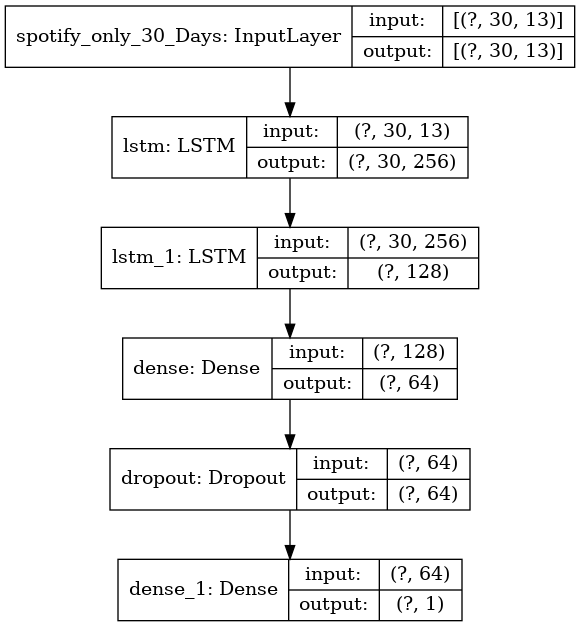

In [30]:
# Show an example model architectures
model = build_lstm(depression_feature_sets[1], model_names[1])
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='HR', expand_nested=False, dpi=96)

### Train Model

In [22]:
model_to_performances = defaultdict(list) # array of MAE values (one for each split)
model_to_predictions = defaultdict(list) # 1D np array of predictions for ALL splits

In [38]:
# Get true labels (test labels listed in order from split 1 to split K)
all_test_labels = get_kfold_labels(depression_labels)

In [24]:
# Get performance of baseline models
zero_rule_performance(depression_labels)
one_month_trailing_avg_performance(trend_to_predict='depression')

In [25]:
# Cross validate all LSTM models
cross_validate(depression_feature_sets, depression_labels, model_names)

Fold 0 - MAE of model trends_only on Test Set: 2.785505533218384
Fold 1 - MAE of model trends_only on Test Set: 3.427152395248413
Fold 2 - MAE of model trends_only on Test Set: 2.160015821456909
Fold 3 - MAE of model trends_only on Test Set: 2.534736156463623
Fold 4 - MAE of model trends_only on Test Set: 3.244156837463379
Fold 5 - MAE of model trends_only on Test Set: 3.4893081188201904
Fold 6 - MAE of model trends_only on Test Set: 1.9350796937942505
Fold 7 - MAE of model trends_only on Test Set: 3.278440237045288
Fold 8 - MAE of model trends_only on Test Set: 3.1668405532836914
Fold 9 - MAE of model trends_only on Test Set: 3.3697397708892822

Fold 0 - MAE of model spotify_only on Test Set: 0.7895780205726624
Fold 1 - MAE of model spotify_only on Test Set: 0.8410182595252991
Fold 2 - MAE of model spotify_only on Test Set: 1.0129477977752686
Fold 3 - MAE of model spotify_only on Test Set: 1.1000785827636719
Fold 4 - MAE of model spotify_only on Test Set: 1.0223634243011475
Fold 5 - M

In [45]:
# Save Results
performance_across_folds = pd.DataFrame.from_dict(model_to_performances)
performance_across_folds.to_csv('./results/10-fold-cv-results-depression.csv', index=False)

# Save predictions to regenerate scatter plots
with open('./results/10-fold-cv-predictions-depression.pkl', 'wb') as handle:
    pickle.dump(model_to_predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save labels to regenerate scatter plots
with open('./results/10-fold-cv-labels-depressions.pkl', 'wb') as handle:
    pickle.dump(all_test_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Show Depression Results

In [289]:
# Obtain results
performance_across_folds = pd.read_csv('./results/10-fold-cv-results-depression.csv')
with open('./results/10-fold-cv-predictions-depression.pkl', 'rb') as handle:
    predictions_across_folds = pickle.load(handle)
    
with open('./results/10-fold-cv-labels-depressions.pkl', 'rb') as handle:
    all_test_labels = pickle.load(handle)

# Sort by performance
sorted_model_names = performance_across_folds.mean(axis=0).sort_values(ascending=False).index.tolist()
performance_across_folds = performance_across_folds[sorted_model_names]
performance_across_folds

,zero_rule,one_month_trailing_average,trends_only,spotify_trends,spotify_only,nyt_trends,nyt_only,spotify_nyt_trends,spotify_nyt
0,5.431384,4.747134,3.383602,0.912120,0.803477,0.837286,0.715191,0.561185,0.796774
1,5.649418,4.762197,2.292748,1.412155,0.971192,0.692916,1.010424,0.752560,0.655273
2,5.450733,4.534572,5.108796,0.669460,0.872320,0.784187,0.678518,0.752714,0.601800
3,5.089193,4.455389,4.041408,0.789148,0.868361,1.791560,0.702899,0.672228,0.711749
4,5.238962,4.396380,3.442170,0.923610,1.046658,0.901451,0.654785,0.625143,0.696014
5,5.165047,4.605616,2.353773,2.157171,1.353496,0.690593,0.907317,0.761269,0.535956
6,5.175296,4.681940,2.306045,1.311155,1.135403,0.767223,0.899188,0.663274,0.739470
7,5.704263,4.408535,2.847516,0.807767,1.053978,0.611079,0.785183,1.258111,0.667453
8,5.433268,4.626594,2.189153,0.889814,0.884121,0.705236,0.728709,0.706889,0.599493
9,5.305170,4.739393,2.260414,0.877858,0.970060,0.643897,1.210128,0.719290,0.618409


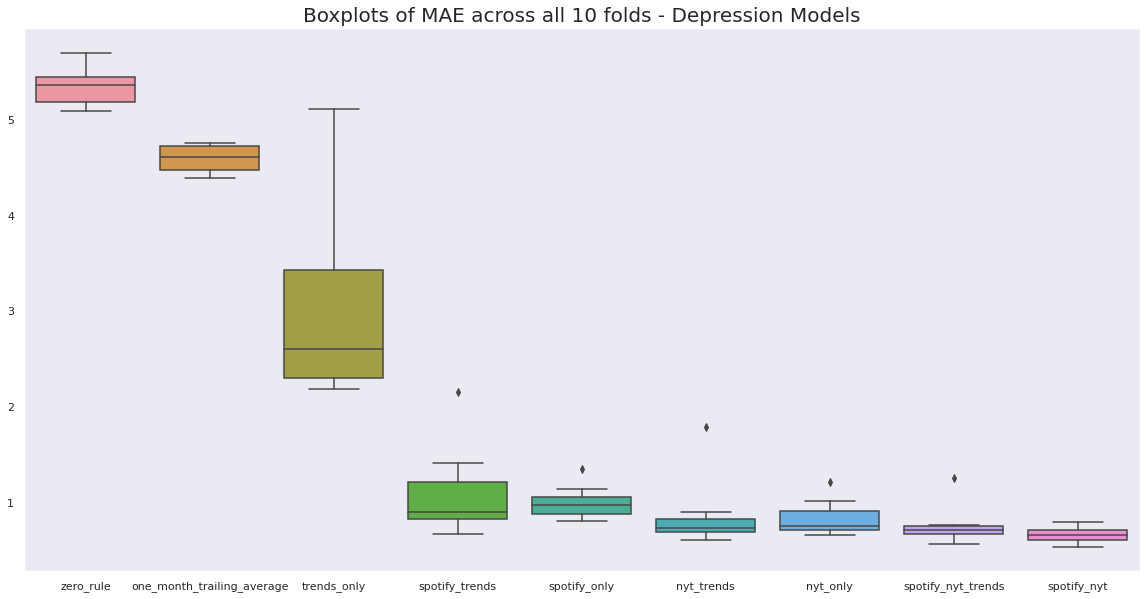

In [290]:
# K-Fold performance boxplots
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('Boxplots of MAE across all 10 folds - Depression Models',  fontsize=20)
sns.boxplot(ax=ax, data=performance_across_folds)
plt.savefig('./figures/depression/boxplot_all_models.png')

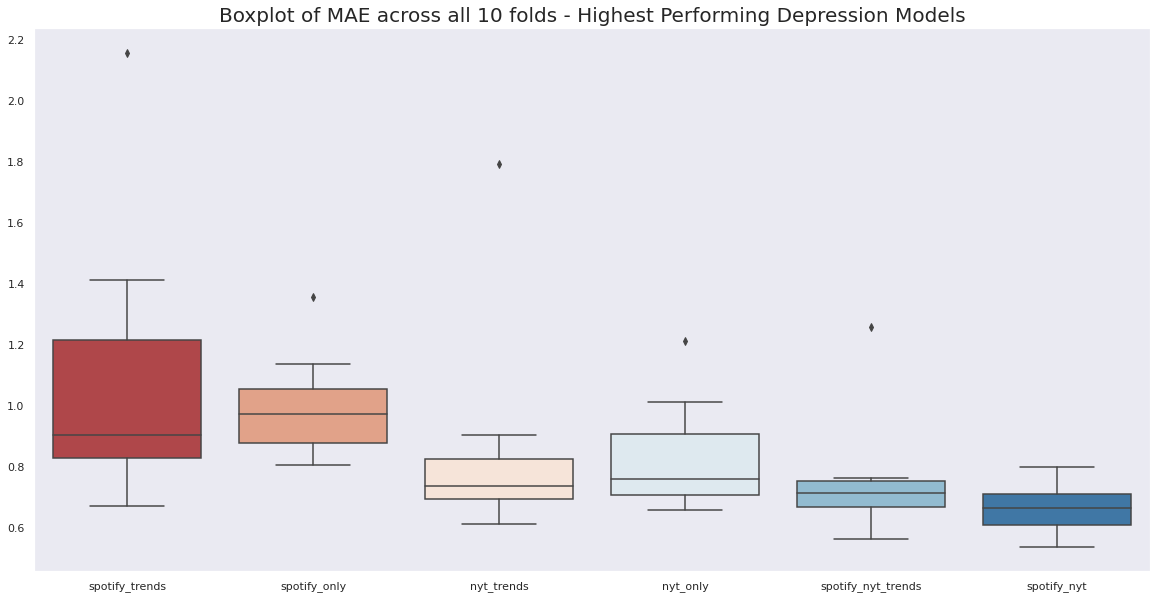

In [291]:
# Zoom in on the most performant models
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('Boxplot of MAE across all 10 folds - Highest Performing Depression Models',  fontsize=20)
sns.boxplot(ax=ax, data=performance_across_folds.iloc[:, 3:])
plt.savefig('./figures/depression/boxplot_best_models.png')

In [292]:
# Get mean performance across folds
pd.DataFrame(performance_across_folds.mean(axis=0).sort_values()).T

,spotify_nyt,spotify_nyt_trends,nyt_only,nyt_trends,spotify_only,spotify_trends,trends_only,one_month_trailing_average,zero_rule
0,0.662239,0.747266,0.829234,0.842543,0.995906,1.075026,3.022563,4.595775,5.364274


In [293]:
# Get the best performance across folds
pd.DataFrame(performance_across_folds.min(axis=0).sort_values()).T

,spotify_nyt,spotify_nyt_trends,nyt_trends,nyt_only,spotify_trends,spotify_only,trends_only,one_month_trailing_average,zero_rule
0,0.535956,0.561185,0.611079,0.654785,0.66946,0.803477,2.189153,4.39638,5.089193


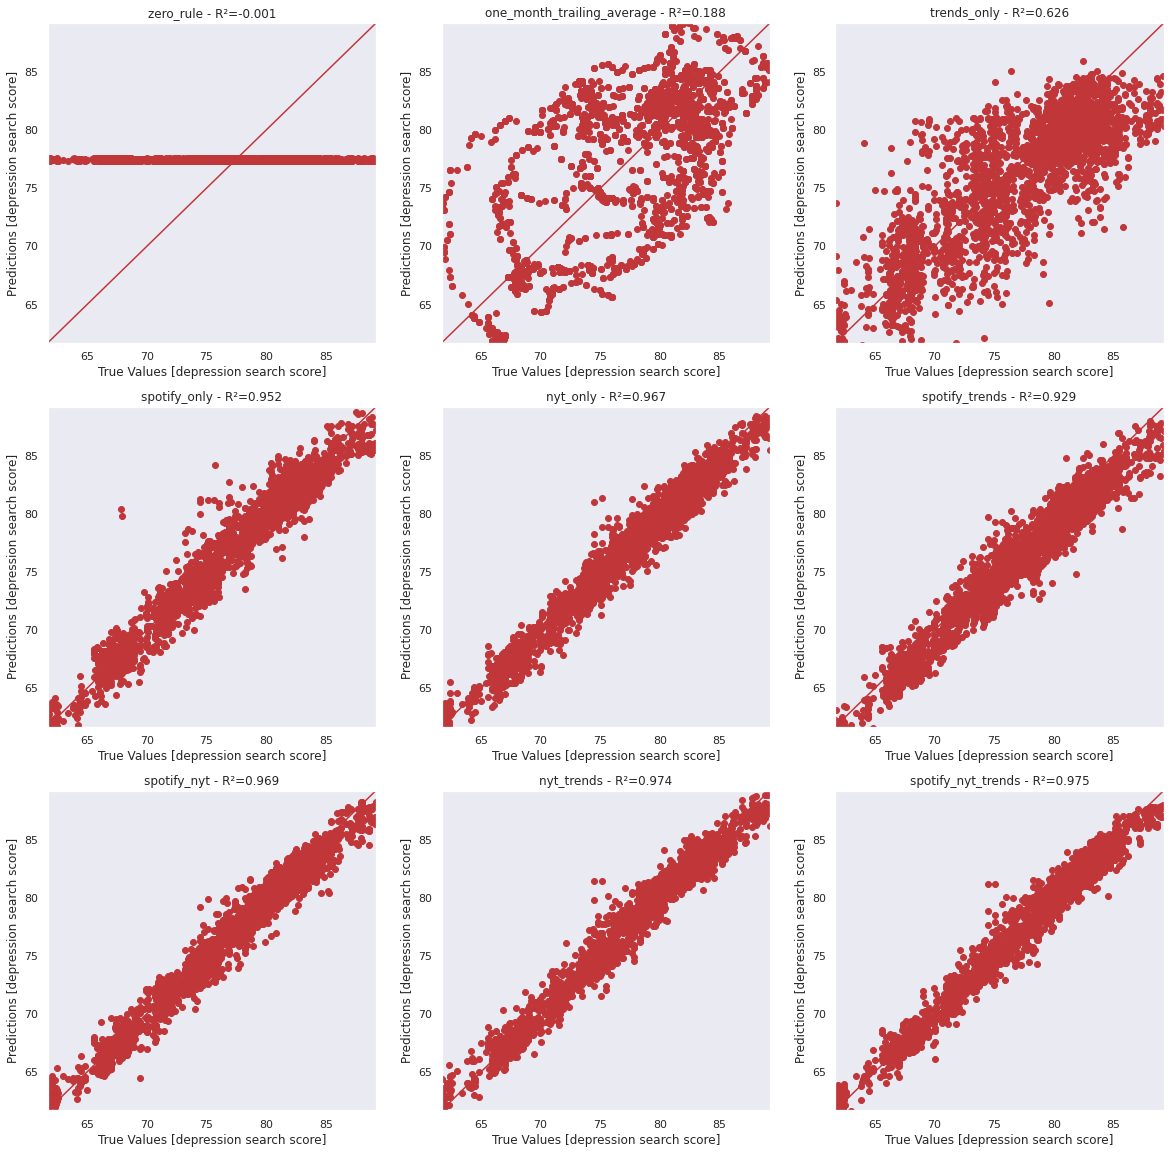

In [294]:
fig=plt.figure(figsize=(20, 20))

# 9 scatter plots - one for each model
columns = 3
rows = 3

for i, model_name in enumerate(predictions_across_folds, 1):
    fig.add_subplot(rows, columns, i)
    all_test_predictions = predictions_across_folds[model_name]
    plot_predictions(all_test_predictions, 
                     all_test_labels, 
                     model_name, 
                     label_name='depression search score')
    
plt.savefig('./figures/depression/all_models_prediction_scatter_plot.png')
plt.show()

## Get Results for Anxiety

In [19]:
# Obtain data
anxiety_feature_sets, anxiety_labels, model_names = data_labels_and_models(trend_to_predict='anxiety')

In [53]:
# Keep track of model performance
model_to_performances = defaultdict(list) # array of MAE values (one for each split)
model_to_predictions = defaultdict(list) # 1D np array of predictions for ALL splits

In [22]:
# Get true labels (test labels listed in order from split 1 to split K)
all_test_labels = get_kfold_labels(anxiety_labels)

In [55]:
# Get performance of baseline models
zero_rule_performance(anxiety_labels)
one_month_trailing_avg_performance(trend_to_predict='anxiety')

In [56]:
cross_validate(anxiety_feature_sets, anxiety_labels, model_names)

Fold 0 - MAE of model trends_only on Test Set: 2.059466600418091
Fold 1 - MAE of model trends_only on Test Set: 2.8705713748931885
Fold 2 - MAE of model trends_only on Test Set: 2.590761423110962
Fold 3 - MAE of model trends_only on Test Set: 3.287386417388916
Fold 4 - MAE of model trends_only on Test Set: 2.944650650024414
Fold 5 - MAE of model trends_only on Test Set: 2.9444215297698975
Fold 6 - MAE of model trends_only on Test Set: 2.44696307182312
Fold 7 - MAE of model trends_only on Test Set: 3.394414186477661
Fold 8 - MAE of model trends_only on Test Set: 3.4842147827148438
Fold 9 - MAE of model trends_only on Test Set: 2.620210886001587

Fold 0 - MAE of model spotify_only on Test Set: 1.1941392421722412
Fold 1 - MAE of model spotify_only on Test Set: 1.2646639347076416
Fold 2 - MAE of model spotify_only on Test Set: 2.351076126098633
Fold 3 - MAE of model spotify_only on Test Set: 1.0235490798950195
Fold 4 - MAE of model spotify_only on Test Set: 1.2532472610473633
Fold 5 - MAE 

In [32]:
# Run Trends only model again (we accidentally lost this data by setting its entry in our dictionary to a blank list)
cross_validate([anxiety_feature_sets[0]], anxiety_labels, [model_names[0]])

Fold 0 - MAE of model trends_only on Test Set: 3.963470220565796
Fold 1 - MAE of model trends_only on Test Set: 2.7825236320495605
Fold 2 - MAE of model trends_only on Test Set: 2.4361672401428223
Fold 3 - MAE of model trends_only on Test Set: 2.343508243560791
Fold 4 - MAE of model trends_only on Test Set: 3.223816156387329
Fold 5 - MAE of model trends_only on Test Set: 4.61335563659668
Fold 6 - MAE of model trends_only on Test Set: 3.052300214767456
Fold 7 - MAE of model trends_only on Test Set: 5.991588592529297
Fold 8 - MAE of model trends_only on Test Set: 2.3384978771209717
Fold 9 - MAE of model trends_only on Test Set: 3.799409866333008



In [58]:
# Save Results
performance_across_folds = pd.DataFrame.from_dict(model_to_performances)
performance_across_folds.to_csv('./results/10-fold-cv-results-anxiety.csv', index=False)

# Save predictions to regenerate scatter plots
with open('./results/10-fold-cv-predictions-anxiety.pkl', 'wb') as handle:
    pickle.dump(model_to_predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Save labels to regenerate scatter plots   
with open('./results/10-fold-cv-labels-anxiety.pkl', 'wb') as handle:
    pickle.dump(all_test_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Show Anxiety Results

In [295]:
# Show results
performance_across_folds = pd.read_csv('./results/10-fold-cv-results-anxiety.csv')

with open('./results/10-fold-cv-predictions-anxiety.pkl', 'rb') as handle:
    predictions_across_folds = pickle.load(handle)
    
with open('./results/10-fold-cv-labels-anxiety.pkl', 'rb') as handle:
    all_test_labels = pickle.load(handle)

# Sort by performance
sorted_model_names = performance_across_folds.mean(axis=0).sort_values(ascending=False).index.tolist()
performance_across_folds = performance_across_folds[sorted_model_names]
performance_across_folds

,zero_rule,one_month_trailing_average,trends_only,spotify_only,spotify_trends,spotify_nyt_trends,nyt_trends,nyt_only,spotify_nyt
0,9.597924,4.401828,3.963470,1.194139,0.828136,0.980404,0.857039,0.727720,0.964750
1,9.379154,4.102940,2.782524,1.264664,0.955624,1.129935,0.908150,0.874177,0.606395
2,9.081457,3.942923,2.436167,2.351076,1.595015,0.681940,0.779498,0.788432,0.862591
3,9.053321,4.132580,2.343508,1.023549,1.160122,1.235885,0.906335,0.944499,0.857977
4,9.074830,4.323686,3.223816,1.253247,0.827499,0.940099,0.933510,0.930378,0.850903
5,9.697404,4.241271,4.613356,1.430777,1.133811,0.943921,0.774332,0.871564,0.859990
6,8.528560,4.209955,3.052300,0.959002,0.892057,1.016404,0.986951,0.878825,0.751414
7,9.074830,4.323686,5.991589,2.103924,1.405475,0.845830,0.826999,0.815188,0.594278
8,9.088654,4.113539,2.338498,1.823391,0.918898,0.852239,0.811110,0.958865,0.773747
9,9.194491,3.867016,3.799410,1.349981,1.089175,0.949925,1.181970,0.815121,0.813414


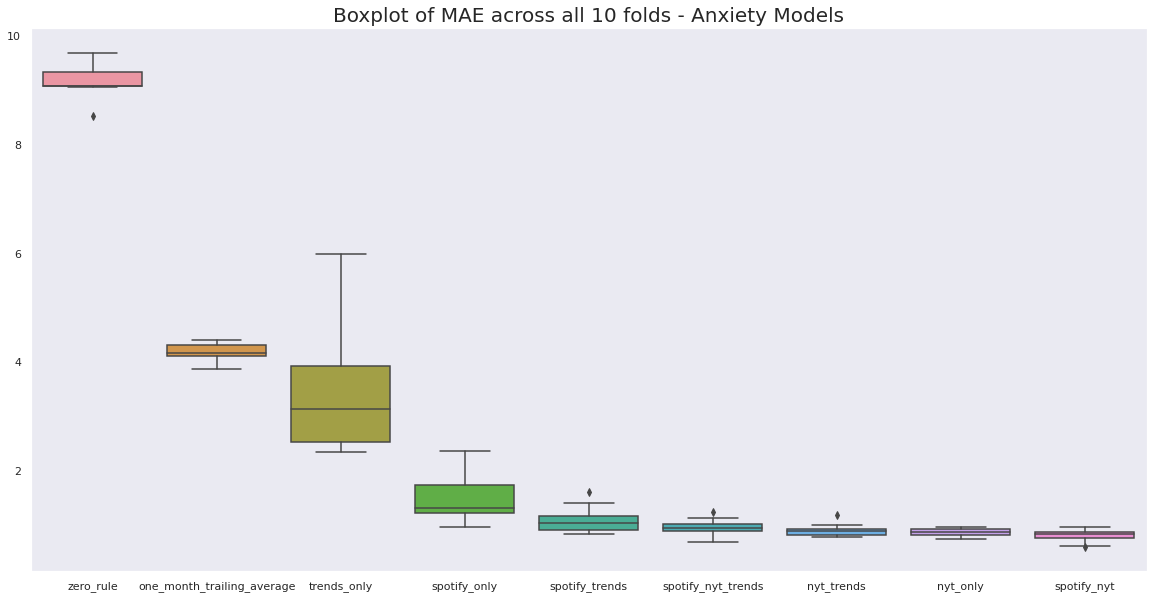

In [296]:
# K-Fold performance boxplots
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Boxplot of MAE across all 10 folds - Anxiety Models',  fontsize=20)
sns.boxplot(ax=ax, data=performance_across_folds)
plt.savefig('./figures/anxiety/boxplot_all_models.png')

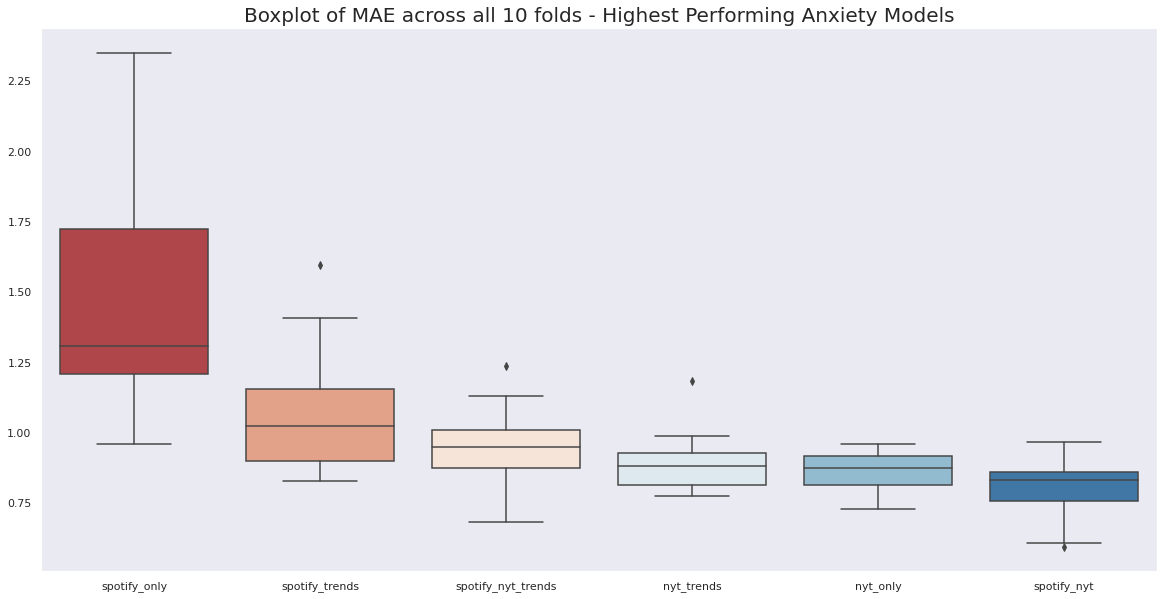

In [297]:
# Zoom in on the most performant models
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Boxplot of MAE across all 10 folds - Highest Performing Anxiety Models',  fontsize=20)
sns.boxplot(ax=ax, data=performance_across_folds.iloc[:, 3:])
plt.savefig('./figures/anxiety/boxplot_best_models.png')

In [298]:
# Get mean performance across folds
pd.DataFrame(performance_across_folds.mean(axis=0).sort_values()).T

,spotify_nyt,nyt_only,nyt_trends,spotify_nyt_trends,spotify_trends,spotify_only,trends_only,one_month_trailing_average,zero_rule
0,0.793546,0.860477,0.896589,0.957658,1.080581,1.475375,3.454464,4.165942,9.177063


In [299]:
# Get the best performance across folds
pd.DataFrame(performance_across_folds.min(axis=0).sort_values()).T

,spotify_nyt,spotify_nyt_trends,nyt_only,nyt_trends,spotify_trends,spotify_only,trends_only,one_month_trailing_average,zero_rule
0,0.594278,0.68194,0.72772,0.774332,0.827499,0.959002,2.338498,3.867016,8.52856


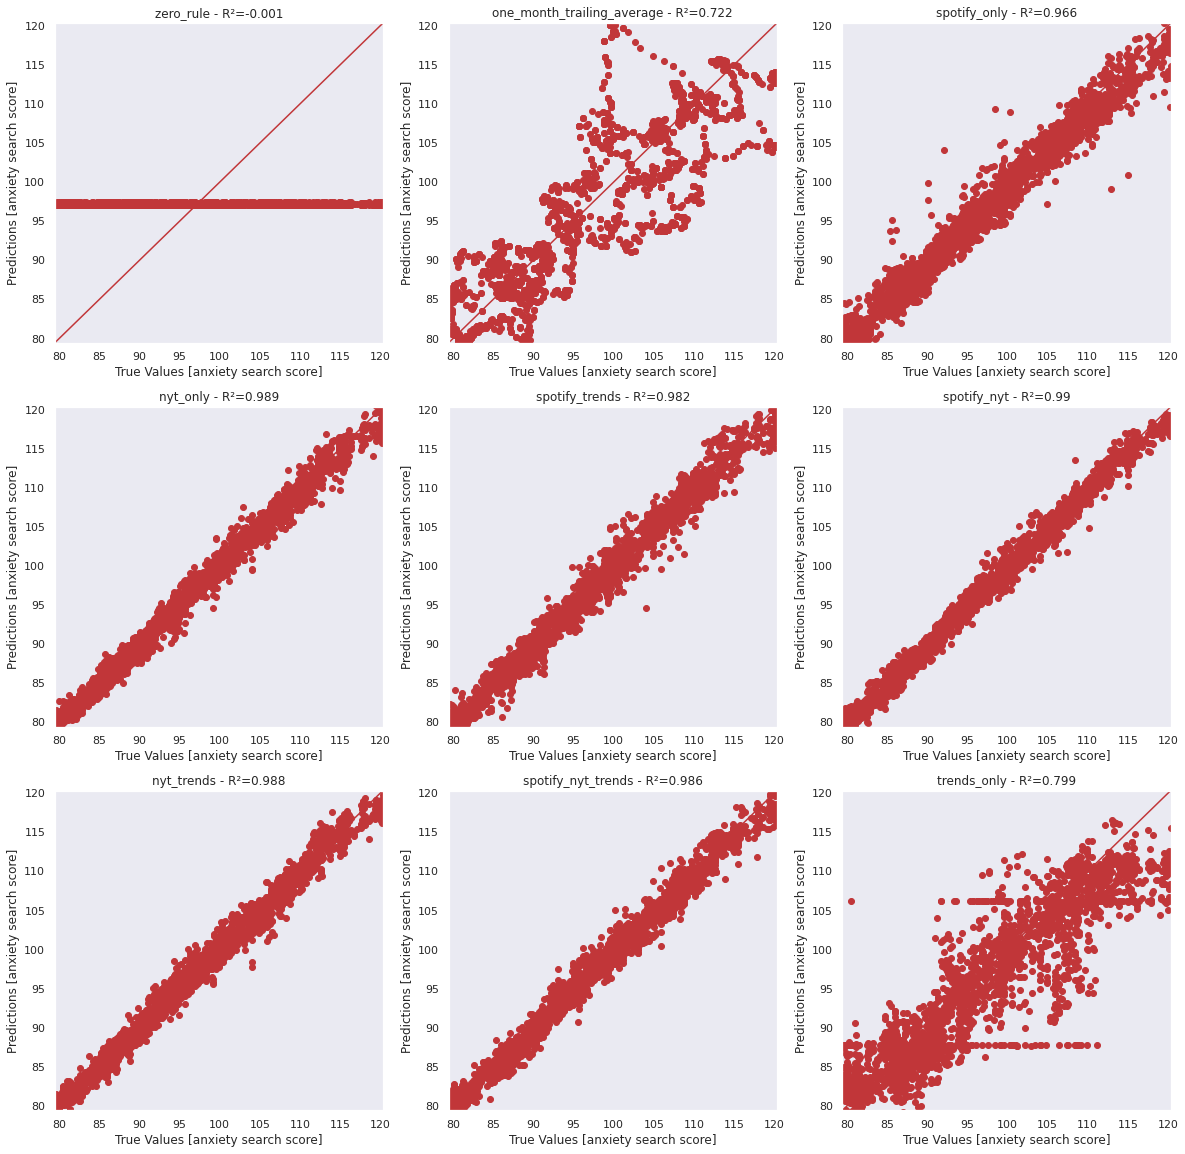

In [300]:
# Print True Values / Prediction Scatter Plots for all models
fig=plt.figure(figsize=(20, 20))

# 9 scatter plots - one for each model
columns = 3
rows = 3

for i, model_name in enumerate(predictions_across_folds, 1):
    fig.add_subplot(rows, columns, i)
    all_test_predictions = predictions_across_folds[model_name]
    plot_predictions(all_test_predictions, 
                     all_test_labels, 
                     model_name, 
                     label_name='anxiety search score')
    
plt.savefig('./figures/anxiety/all_models_prediction_scatter_plot.png')
plt.show()